In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2016-01-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-06-01"  # Enddatum, bis zu dem Daten überprüft werden sollen

# Daten aus der Tabelle in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE timestamp >= ? AND timestamp <= ?"
df = pd.read_sql(select_query, con=engine, params=(start_date, end_date))

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(df.head())

   id  timestamp company       open       high        low      close  \
0   1 2016-01-04    AAPL  25.652500  26.342501  25.500000  26.337500   
1   2 2016-01-05    AAPL  26.437500  26.462500  25.602501  25.677500   
2   3 2016-01-06    AAPL  25.139999  25.592501  24.967501  25.174999   
3   4 2016-01-07    AAPL  24.670000  25.032499  24.107500  24.112499   
4   5 2016-01-08    AAPL  24.637501  24.777500  24.190001  24.240000   

      volume  
0  270597600  
1  223164000  
2  273829600  
3  324377600  
4  283192000  


<Axes: ylabel='Density'>

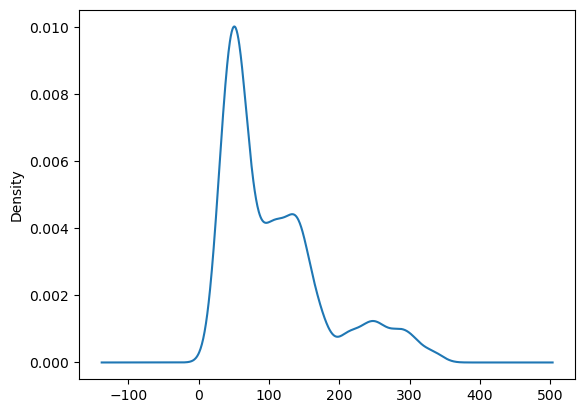

In [3]:
#Distribution of the dataset
df_close = df['close']
df_close.plot(kind='kde')

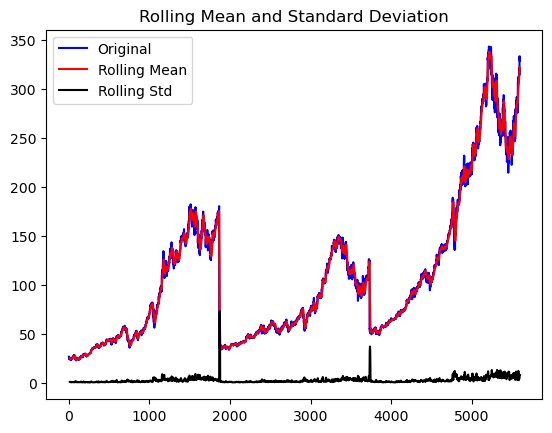

Results of dickey fuller test
Test Statistics                  -0.183782
p-value                           0.940427
No. of lags used                 10.000000
Number of observations used    5587.000000
critical value (1%)              -3.431521
critical value (5%)              -2.862057
critical value (10%)             -2.567045
dtype: float64


In [4]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

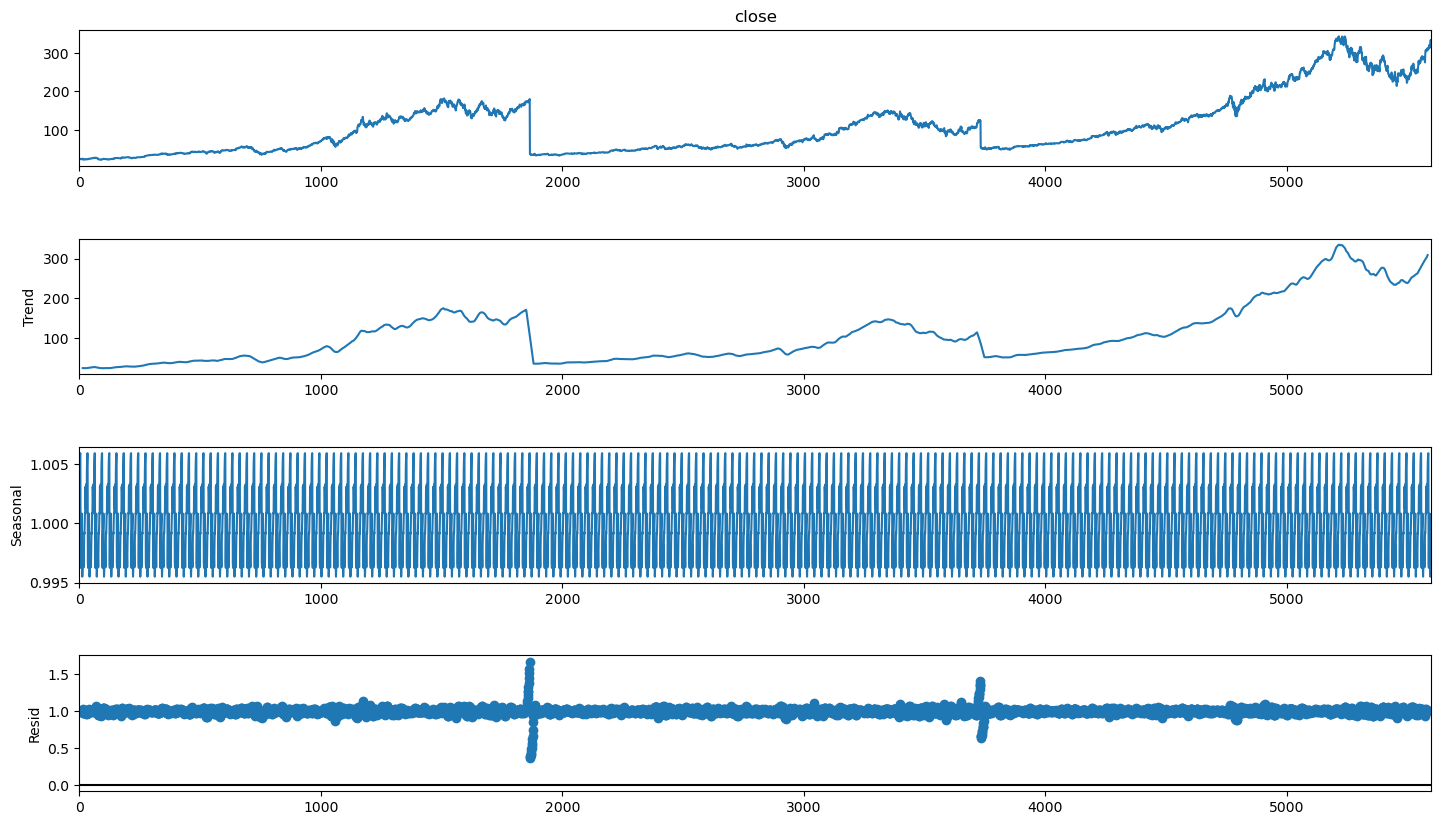

In [5]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


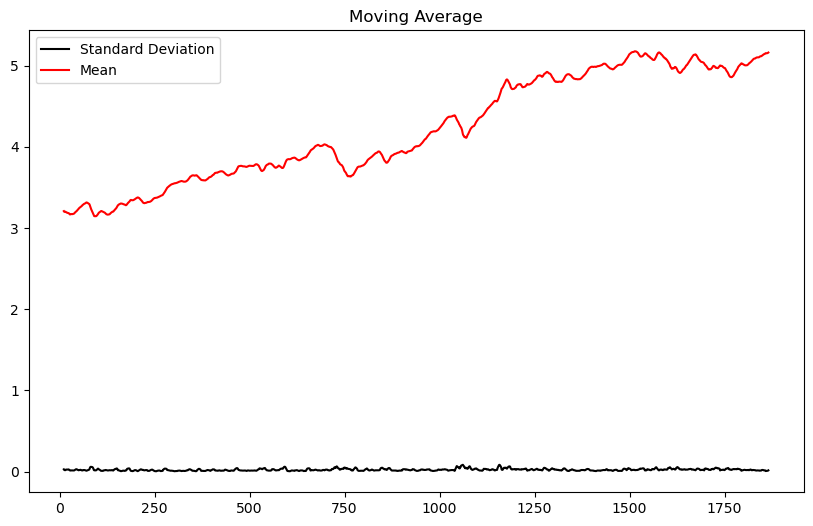

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

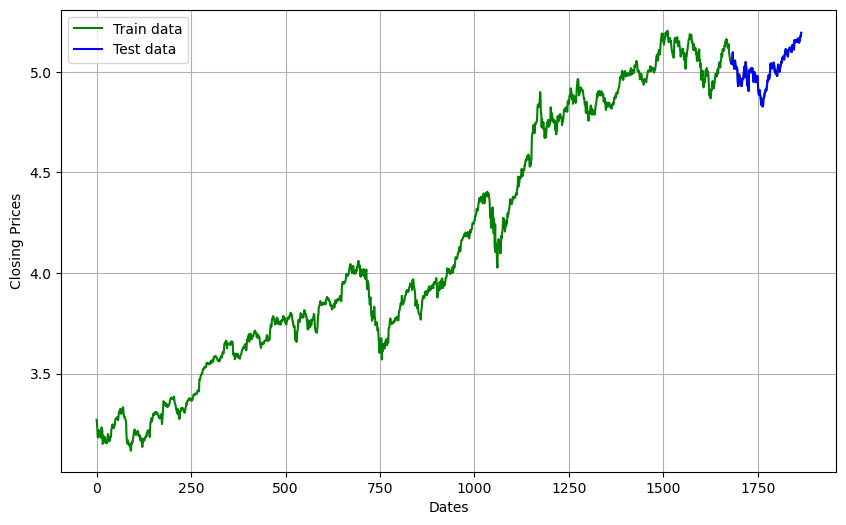

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8556.818, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8569.991, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8569.743, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8552.855, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8568.046, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8568.087, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8566.023, Time=1.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8564.810, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.874 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1676
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4287.995
Date:                Thu, 22 Jun 2023   AIC                          -8569.991
Time:                       

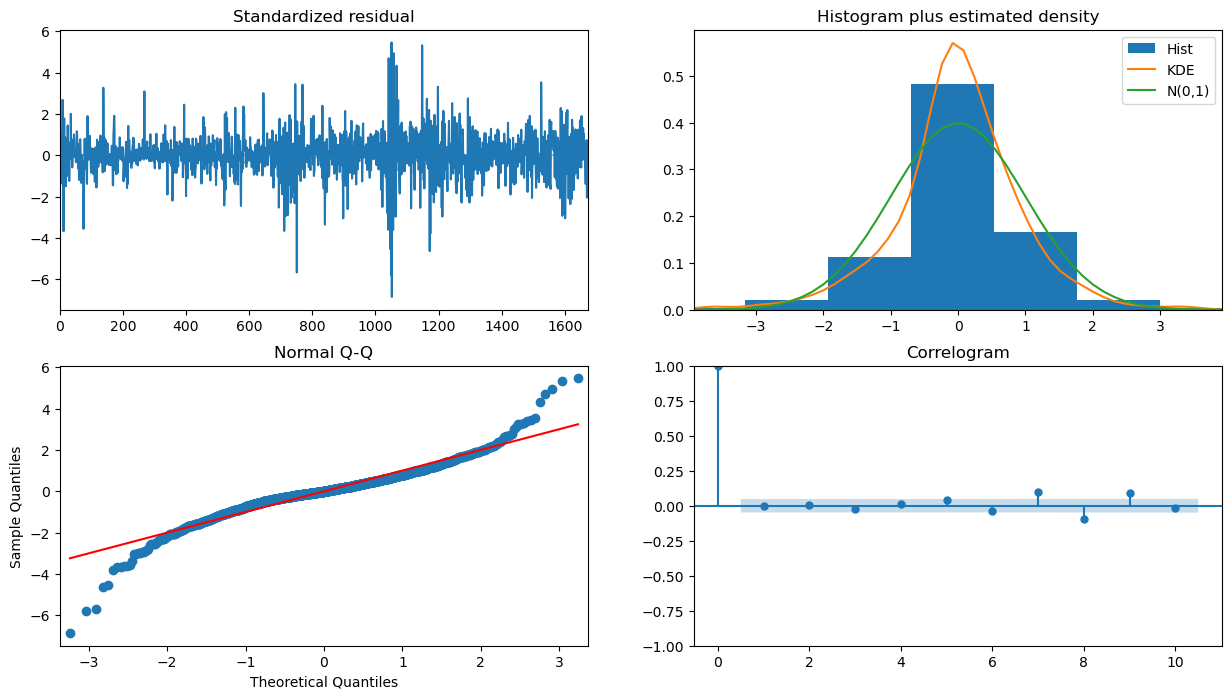

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
# Import the necessary classes
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
model = SARIMAX(train_data, order=(1, 1, 0))
fitted = model.fit(disp=-1)
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1676
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4284.405
Date:                Thu, 22 Jun 2023   AIC                          -8564.810
Time:                        00:07:57   BIC                          -8553.963
Sample:                             0   HQIC                         -8560.792
                               - 1676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0911      0.015     -6.134      0.000      -0.120      -0.062
sigma2         0.0004   6.68e-06     52.562      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

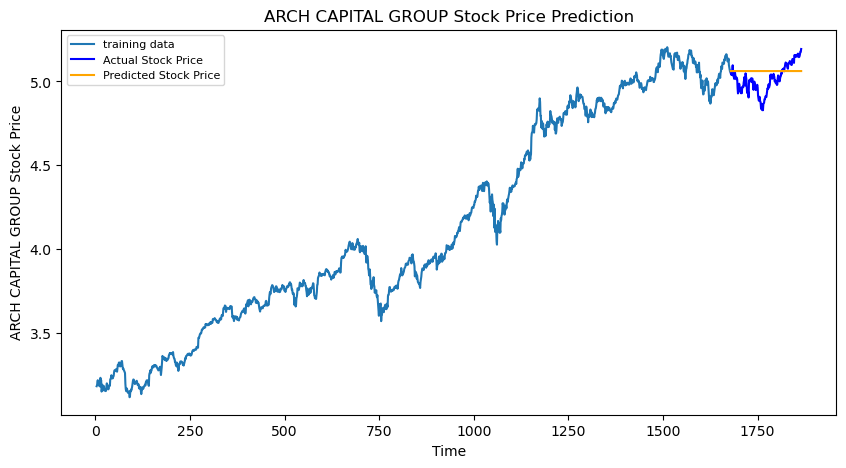

In [21]:
# Forecast
fc = fitted.forecast(321, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
##                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
# Forecast
forecast_result = fitted.forecast(321, alpha=0.05)  # 95% conf
fc = forecast_result[0]
se = forecast_result[1]
conf = forecast_result[2]

# Create a new index
forecast_index = pd.RangeIndex(start=test_data.index[-1]+1, stop=test_data.index[-1]+1+len(fc), step=1)

# Make as pandas series
fc_series = pd.Series(fc, index=forecast_index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

KeyError: 0

In [18]:
# Forecast
forecast_result = fitted.forecast(321, alpha=0.05)  # 95% conf
fc = forecast_result[0]
se = forecast_result[1]
conf = forecast_result[2]

KeyError: 0